# Background
Due to these businesses model, we will be looking at carparks that offer ELECTRONIC PARKING and WHOLE DAY short-term parking are applicable.


### Objective
- The carparks that are most under utilized
- The largest carparks
- The Fluctuations in availability look like on the weekends

Due to the business model, only carparks that offer ELECTRONIC PARKING and WHOLE DAY short- term parking are applicable.

# Import Libraries

In [1]:
import datetime
import requests
import json

import random
import time

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# show all rows and columns
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
pd.options.display.max_colwidth = 1000

# Carpark Reference Data

Loading in the initial dataset which contains unique carpark number, its address, x and y coordinates, type of parking system employed, and if it allows short term parking and if it allows night time parking. Here's a small glimpse at the structure of the car park data. 

In [2]:
carpark = pd.read_csv('./datasets/hdb-carpark-information.csv')
display(carpark.head())
print(f'Total Carparks in SG: {carpark.car_park_no.nunique()}')

# # Check if the there's any varying categories within the target column
# print(f'Types of Parking System: {carpark.type_of_parking_system.unique()}')
# print(f'Types of Short term Parking: {carpark.short_term_parking.unique()}')

,car_park_no,address,x_coord,y_coord,car_park_type,type_of_parking_system,short_term_parking,free_parking,night_parking,car_park_decks,gantry_height,car_park_basement
0,ACB,BLK 270/271 ALBERT CENTRE BASEMENT CAR PARK,30314.7936,31490.4942,BASEMENT CAR PARK,ELECTRONIC PARKING,WHOLE DAY,NO,YES,1,1.8,Y
1,ACM,BLK 98A ALJUNIED CRESCENT,33758.4143,33695.5198,MULTI-STOREY CAR PARK,ELECTRONIC PARKING,WHOLE DAY,SUN & PH FR 7AM-10.30PM,YES,5,2.1,N
2,AH1,BLK 101 JALAN DUSUN,29257.7203,34500.3599,SURFACE CAR PARK,ELECTRONIC PARKING,WHOLE DAY,SUN & PH FR 7AM-10.30PM,YES,0,0.0,N
3,AK19,BLOCK 253 ANG MO KIO STREET 21,28185.4359,39012.6664,SURFACE CAR PARK,COUPON PARKING,7AM-7PM,NO,NO,0,0.0,N
4,AK31,BLK 302/348 ANG MO KIO ST 31,29482.0290,38684.1754,SURFACE CAR PARK,COUPON PARKING,NO,NO,NO,0,0.0,N


Total Carparks in SG: 2158


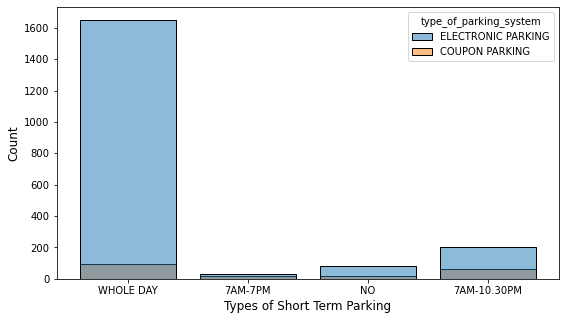

In [3]:
plt.figure(figsize=(9,5))
sns.histplot(carpark, 
             x="short_term_parking", 
             hue="type_of_parking_system", 
             shrink=.8)
plt.ylabel('Count', fontsize=12)
plt.xlabel('Types of Short Term Parking', fontsize=12);

In [4]:
# Select carparks that support both electronic and whole day short term parking
electronic_carpark = carpark[(carpark['type_of_parking_system'] == "ELECTRONIC PARKING") & (carpark['short_term_parking'] == 'WHOLE DAY')]
print(f'Total Carpark (Electronic & Whole Day Only): {electronic_carpark.shape[0]}')
print(f'Total Carpark (Electronic & Whole Day Only): {np.round(electronic_carpark.shape[0]/carpark.shape[0]*100,2)}%')

Total Carpark (Electronic & Whole Day Only): 1650
Total Carpark (Electronic & Whole Day Only): 76.46%


The graph above shows that there are in fact two types of parking systems and majority of the them are electronic(shown in the map below as well, highlighted in grey). 

![map](./images/tableau_type_of_parking.png "carpark types")

Additionally, out of 2158 carparks in Singapore, more than half of them supports whole day parking (also shown in the graph below, highlighted in light green). Since the goal is to build a tool for whole-day parking that support electronic, we will filter out all the parking lots that don't support this type of transaction. 

![map](./images/tableau_short_term_parking.png "Types of short term parking")

With the help of Tableau, we can now see the spatial distribution of carparks across Singapore. It’s definite that most lots support whole day and electronic, with 7:00 AM - 7:00 AM & 7:00 AM - 10:00 PM and coupon car parks peppered throughout the island.

In [5]:
# # For Checking Purposes - Turns out there are carpark that is not in the carpark Reference Data
# carpark[carpark['car_park_no']=='CKM5'] 

# Carpark Availability Data

Data for the carpark availability in Singapore: 
- Retrieved every minute 
- Use the date_time parameter to retrieve the latest carpark availability at that moment in time 
- Limited to 60 requests per minute per API key

## Retreiving Data
Looping through data, an hour at a time for one week. Starting from a random Monday.

In [6]:
# url = "https://api.data.gov.sg/v1/transport/carpark-availability"

# days = 7 # Number of days of data to extract
from_date = '2021-03-22T00:30:00' # Date of when to extract from - Monday
# from_date_iso = datetime.datetime.fromisoformat(from_date) 
# date_range = [from_date_iso + datetime.timedelta(hours=i) for i in range(24*days)] # Hourly

# data = []
# index = 1
# sleep_duration = 5

# print("Scanning...")
# for date in date_range:
#     params = {'date_time': date.isoformat()}
#     print(f'{index}. Retreiving Data for:', date)
#     response = requests.get(url, params=params)

#     while response.status_code != 200:
#         print(f'Status error {response.status_code}, Retrying in {sleep_duration} seconds.')
#         time.sleep(sleep_duration)
#         response = requests.get(url, params=params)
    
#     index += 1
        
#     current_dict = json.loads(response.text)['items'][0]['carpark_data']
#     data.extend(current_dict)

#     print('Next Fetch in:', sleep_duration, 'seconds')
#     time.sleep(sleep_duration)
    
# with open('./datasets/carpark_availability.json', 'w') as json_file:
#     json.dump(data, json_file)
    
# print('Completed & Saved')

### Convert json to Dataframe

In [7]:
# Load json file
with open('./datasets/carpark_availability.json') as f:
    data = json.load(f)

In [8]:
df = pd.DataFrame(data)
print(df.shape)
display(df.head(10))
display(df.tail(10))

(349565, 3)


,carpark_info,carpark_number,update_datetime
0,"[{'total_lots': '91', 'lot_type': 'C', 'lots_available': '38'}]",HE12,2021-03-22T00:03:10
1,"[{'total_lots': '583', 'lot_type': 'C', 'lots_available': '483'}]",HLM,2021-03-22T00:03:25
2,"[{'total_lots': '322', 'lot_type': 'C', 'lots_available': '114'}]",RHM,2021-03-22T00:03:10
3,"[{'total_lots': '97', 'lot_type': 'C', 'lots_available': '86'}]",BM29,2021-03-22T00:03:12
4,"[{'total_lots': '96', 'lot_type': 'C', 'lots_available': '63'}]",Q81,2021-03-22T00:03:09
5,"[{'total_lots': '176', 'lot_type': 'C', 'lots_available': '137'}]",C20,2021-03-22T00:03:13
6,"[{'total_lots': '228', 'lot_type': 'C', 'lots_available': '167'}]",FR3M,2021-03-22T00:03:38
7,"[{'total_lots': '289', 'lot_type': 'C', 'lots_available': '92'}]",C32,2021-03-22T00:03:23
8,"[{'total_lots': '332', 'lot_type': 'C', 'lots_available': '100'}]",C6,2021-03-22T00:03:34
9,"[{'total_lots': '273', 'lot_type': 'C', 'lots_available': '67'}]",TG2,2021-03-22T00:03:17


,carpark_info,carpark_number,update_datetime
349555,"[{'total_lots': '278', 'lot_type': 'C', 'lots_available': '233'}]",PDL2,2021-03-28T23:08:21
349556,"[{'total_lots': '1469', 'lot_type': 'C', 'lots_available': '1463'}]",NT5,2021-03-28T23:07:24
349557,"[{'total_lots': '1129', 'lot_type': 'C', 'lots_available': '537'}]",A61,2021-03-28T23:09:47
349558,"[{'total_lots': '500', 'lot_type': 'C', 'lots_available': '54'}]",Y38,2021-03-28T23:10:10
349559,"[{'total_lots': '50', 'lot_type': 'H', 'lots_available': '50'}, {'total_lots': '43', 'lot_type': 'Y', 'lots_available': '40'}]",GE5,2021-03-28T22:55:55
349560,"[{'total_lots': '250', 'lot_type': 'C', 'lots_available': '249'}]",BA4,2021-03-28T23:01:42
349561,"[{'total_lots': '10', 'lot_type': 'C', 'lots_available': '0'}]",JS1L,2021-03-28T23:10:55
349562,"[{'total_lots': '333', 'lot_type': 'C', 'lots_available': '131'}]",A26,2021-03-28T23:02:14
349563,"[{'total_lots': '200', 'lot_type': 'C', 'lots_available': '199'}]",B65M,2021-03-28T23:08:41
349564,"[{'total_lots': '100', 'lot_type': 'C', 'lots_available': '99'}]",B65L,2021-03-28T23:08:41


Having a closer look at the data shown here, some of the carparks appeared to have more than one carpark information, due to the distinction of the lot type, which will be dealt with later on. First, I will be flattening the data in `carpark_info` to get the nested data into their respective columns.

In [9]:
df = pd.json_normalize(data, 'carpark_info', ['carpark_number', 'update_datetime'])
print(df.shape)
display(df.head())
display(df.tail())

(391437, 5)


,total_lots,lot_type,lots_available,carpark_number,update_datetime
0,91,C,38,HE12,2021-03-22T00:03:10
1,583,C,483,HLM,2021-03-22T00:03:25
2,322,C,114,RHM,2021-03-22T00:03:10
3,97,C,86,BM29,2021-03-22T00:03:12
4,96,C,63,Q81,2021-03-22T00:03:09


,total_lots,lot_type,lots_available,carpark_number,update_datetime
391432,250,C,249,BA4,2021-03-28T23:01:42
391433,10,C,0,JS1L,2021-03-28T23:10:55
391434,333,C,131,A26,2021-03-28T23:02:14
391435,200,C,199,B65M,2021-03-28T23:08:41
391436,100,C,99,B65L,2021-03-28T23:08:41


In [10]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 391437 entries, 0 to 391436
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   total_lots       391437 non-null  object
 1   lot_type         391437 non-null  object
 2   lots_available   391437 non-null  object
 3   carpark_number   391437 non-null  object
 4   update_datetime  391437 non-null  object
dtypes: object(5)
memory usage: 14.9+ MB


None

In [11]:
df.lot_type.value_counts()

C    324573
L     23688
H     21672
Y     21504
Name: lot_type, dtype: int64

### Split Data (Lot Type)

As mentioned earlier, some carparks has more than one record, which was resulted from the split of the different `lot_type` (C, H, L, Y). There is no/little information regarding the lot type that correspond to the alphabet in the data given in data.gov. Furthermore, Lot type C appear to be the most, which seems reasonable to consider them as car parking lots, as the majority of the vehicle are cars. Therefore, it is assumed here that the alphabets correspond with the vehicle type. Since the business model targets on car sharing, <b>only Lot Type C</b> will be selected for this project. 

<u>For future studies, this can be commented out accordingly or entirely.</u>

In [12]:
df_c = df[df['lot_type']=='C']
print(df_c.shape)

# df_l = df[df['lot_type']=='L']
# print(df_l.shape)

# df_h = df[df['lot_type']=='H']
# print(print(df_h.shape))

# df_y = df[df['lot_type']=='Y']
# print(print(df_y.shape))

df =  df_c

(324573, 5)


## Cleaning up Data

<b>Side Note:</b>

Out of more than 320_000 of the entire data, almost 3.5% (more than 11_000) of the data here are irrelevent. There are carparks that do not exist in the car reference data (Note for future studies).

In [13]:
print(f'Number of data that are non-targeted: {df[~df.carpark_number.isin(carpark.car_park_no)].shape[0]}')
display(df[~df['carpark_number'].isin(carpark.car_park_no)].head())
print(f"Drop percentage: {np.round(df[~df['carpark_number'].isin(carpark.car_park_no)].shape[0]/df.shape[0]*100,2)}%")

Number of data that are non-targeted: 11253


,total_lots,lot_type,lots_available,carpark_number,update_datetime
40,320,C,181,RCB,2017-03-31T12:00:21
165,192,C,142,CK21,2020-03-26T14:26:12
172,1000,C,19,W2,2017-12-04T10:54:50
173,1000,C,53,W1,2017-12-04T10:54:50
200,25,C,0,EPML,2015-12-30T10:38:36


Drop percentage: 3.47%


#### i. Selecting specific data
The next step would to be remove the availability data that are neither electronic parking nor whole day parking, using the data obtained from carpark reference data. 

In [14]:
print(f'Number of data that are non-targeted: {df[~df.carpark_number.isin(electronic_carpark.car_park_no)].shape[0]}')
display(df[~df['carpark_number'].isin(electronic_carpark.car_park_no)].head())
print(f"Drop percentage: {np.round(df[~df['carpark_number'].isin(electronic_carpark.car_park_no)].shape[0]/df.shape[0]*100,2)}%")

Number of data that are non-targeted: 63501


,total_lots,lot_type,lots_available,carpark_number,update_datetime
13,138,C,31,TE14,2021-03-22T00:03:33
22,362,C,94,T50,2021-03-22T00:00:11
23,351,C,42,T51,2021-03-22T00:00:32
34,40,C,15,CY,2021-03-22T00:00:01
37,363,C,49,BE45,2021-03-22T00:04:07


Drop percentage: 19.56%


Although 19.6% seem to be a big drop in data, it corresponded to the number electronic and whole day parking out of all the carparks in Singapore, with an additional consideration of 3% that was mentioned above.

In [15]:
df = df[df['carpark_number'].isin(electronic_carpark.car_park_no)]
print(df.shape)
display(df.head())
print(f'Total Number of Carparks with Data: {df.carpark_number.nunique()}')

(261072, 5)


,total_lots,lot_type,lots_available,carpark_number,update_datetime
0,91,C,38,HE12,2021-03-22T00:03:10
1,583,C,483,HLM,2021-03-22T00:03:25
2,322,C,114,RHM,2021-03-22T00:03:10
3,97,C,86,BM29,2021-03-22T00:03:12
4,96,C,63,Q81,2021-03-22T00:03:09


Total Number of Carparks with Data: 1554


In [16]:
display(df.sort_values('update_datetime').head())
display(df.sort_values('update_datetime').tail())

,total_lots,lot_type,lots_available,carpark_number,update_datetime
198220,75,C,75,B90,2015-03-03T05:02:19
216866,75,C,75,B90,2015-03-03T05:02:19
142323,75,C,75,B90,2015-03-03T05:02:19
144652,75,C,75,B90,2015-03-03T05:02:19
312435,75,C,75,B90,2015-03-03T05:02:19


,total_lots,lot_type,lots_available,carpark_number,update_datetime
389710,591,C,160,J89M,2021-03-28T23:11:22
391342,72,C,8,J74M,2021-03-28T23:11:22
389600,491,C,315,JM15,2021-03-28T23:11:22
389717,1302,C,426,JM28,2021-03-28T23:11:22
390443,444,C,160,PM26,2021-03-28T23:11:45


From the data above and below, `update_datetime` oddly ranges from 2015 to 2021, which produces a bunch duplicated data assuming it continues to scrape the last updated data until there is a new updated one. Therefore I will be dropping data with `update_datetime` that is before the stipulated `from_date` date (that was created for the scraping of data), assuming that this might resulted from an error of the updating system for these carparks, which could give a inaccurate/false results.  

I will also check if there are any other duplicates after.

In [17]:
# Convert update_datetime column to datetime object
df['update_datetime'] = pd.to_datetime(df['update_datetime'])

# filter out data before from_date
df = df[(df['update_datetime'] > from_date)]
display(df.sort_values(by='update_datetime').head())
df.shape

<ipython-input-17-d3e0beb5fc26>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['update_datetime'] = pd.to_datetime(df['update_datetime'])


,total_lots,lot_type,lots_available,carpark_number,update_datetime
3483,194,C,98,TB7,2021-03-22 00:44:16
2758,360,C,286,JKM,2021-03-22 00:44:24
2761,42,C,33,JKS,2021-03-22 00:44:25
3255,433,C,305,JRTM,2021-03-22 00:47:15
2752,149,C,116,HE3,2021-03-22 00:47:19


(253464, 5)

#### ii. Duplicates

In [18]:
# Check drop for Complete Duplicates as they are not required
print("Complete duplicates: ", df.duplicated().sum())
display((df[df.duplicated()]).sort_values(by=['carpark_number','update_datetime']).head())

Complete duplicates:  1230


,total_lots,lot_type,lots_available,carpark_number,update_datetime
110284,285,C,201,ACM,2021-03-23 21:58:55
112604,285,C,201,ACM,2021-03-23 21:58:55
114935,285,C,201,ACM,2021-03-23 21:58:55
117265,285,C,201,ACM,2021-03-23 21:58:55
119601,285,C,201,ACM,2021-03-23 21:58:55


Duplicated data are dropped as well as it does not add any value.

In [19]:
df = df.drop_duplicates()
df.shape

(252234, 5)

#### iii. Missing Values

In [20]:
print((df.isnull().sum())[df.isnull().sum()>0].sort_values(ascending=False))

Series([], dtype: int64)


#### iv. Data Types

Now that data is pretty much cleaned, I will be changing the variables to their respective datatypes for easy and effective handling.

In [21]:
# Integer Varibles
df.total_lots = df.total_lots.astype('int64')
df.lots_available = df.lots_available.astype('int64')

In [23]:
# Save cleaned dataframe into a separate file
df.to_csv("./datasets/carpark_availability_final.csv", index = False)

###  Largest Carpark

In [25]:
df.groupby('carpark_number').total_lots.agg(np.mean).sort_values(ascending=False).head(5)

carpark_number
BJ49    4443.0
CKM5    2754.0
CK58    2637.0
CK52    2064.0
BM10    2000.0
Name: total_lots, dtype: float64

In [26]:
(df[df['carpark_number'] == 'BJ49']).head()

,total_lots,lot_type,lots_available,carpark_number,update_datetime
2942,4443,C,3325,BJ49,2021-03-22 01:02:51
5275,4443,C,3316,BJ49,2021-03-22 02:05:22
7603,4443,C,3319,BJ49,2021-03-22 03:04:53
9933,4443,C,3316,BJ49,2021-03-22 04:07:25
12262,4443,C,3328,BJ49,2021-03-22 05:07:27


In [27]:
display(carpark[carpark['car_park_no'] == 'BJ49'])

,car_park_no,address,x_coord,y_coord,car_park_type,type_of_parking_system,short_term_parking,free_parking,night_parking,car_park_decks,gantry_height,car_park_basement
218,BJ49,BLK 611A/613A/615A/616A BUKIT PANJANG RING ROAD/SENJA ROAD,20006.0358,40760.5616,MULTI-STOREY CAR PARK,ELECTRONIC PARKING,WHOLE DAY,SUN & PH FR 7AM-10.30PM,YES,6,2.15,N


Carpark BJ49 has the most number of parking spaces which seem a little unbelivable at first but according to the carpark reference data, and it appears to be a combination of 4 different block hence the size, hence the largest carpark.

![map](./images/largest_carpark_sg.png "Largest Carpark")

It is always easier to visualize, here you can see that carpark BJ49 has the darkest shade which corresponds with the highest number of lots of 4443. 

## Feature Engineering

In order to look into how well carparks in Singapore are being utilized. I will first engineer a feature that calculates the percentage of usage of every observation. With that information on hand, I will be able to look at the average occupancy of  each carpark over the collected period. 

In [28]:
# Calculate the number of used space in percentage
df['used_space'] = np.round((1 - df['lots_available']/df['total_lots'])*100, 2)

In [29]:
df.sort_values('used_space').head()

,total_lots,lot_type,lots_available,carpark_number,update_datetime,used_space
77510,350,C,350,SB5,2021-03-23 09:06:28,0.0
117961,576,C,576,PRM,2021-03-24 02:22:11,0.0
282867,43,C,43,HG97,2021-03-27 01:26:54,0.0
105449,500,C,500,SB16,2021-03-23 21:18:12,0.0
352998,544,C,544,TJ32,2021-03-28 07:25:31,0.0


In [30]:
# Average occupancy in the collected period
occupancy = pd.DataFrame(df.groupby(by='carpark_number').used_space.agg(np.mean)).sort_values(['used_space'])
display(occupancy.head())
display(occupancy.tail(10))

,used_space
carpark_number,
W94,0.280000
PM15,0.540120
PM2,1.763855
PM4,1.862695
TRS,2.600000


,used_space
carpark_number,
J62,97.103234
BL3,98.337605
BJ62,98.855389
A30,99.650778
TP31,99.784431
A33,100.000000
CR29,100.000000
STM3,100.000000
MLM,100.000000


Carparks W94, PM15, PM2 appear to be the least utilized carparks and this carparks appear to be in the mature estates. On top of that, there are 5 carparks with 100% occupancy which is very unlikely which requires more exploration for future studies. 

In [31]:
occupancy.loc['BJ49']

used_space    15.322275
Name: BJ49, dtype: float64

Even with the largaest carpark, occupancy rate is only at 15%.

## Exploratory Data Analysis

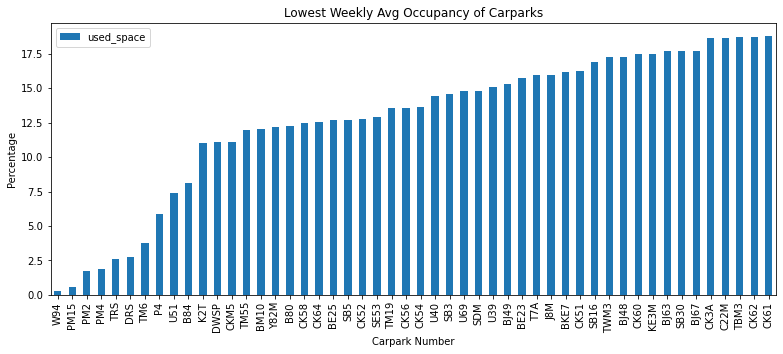

In [32]:
ax = occupancy[0:50].reset_index().plot.bar(x='carpark_number', y='used_space', figsize=(13,5))
ax.set(title='Lowest Weekly Avg Occupancy of Carparks', xlabel='Carpark Number', ylabel='Percentage');

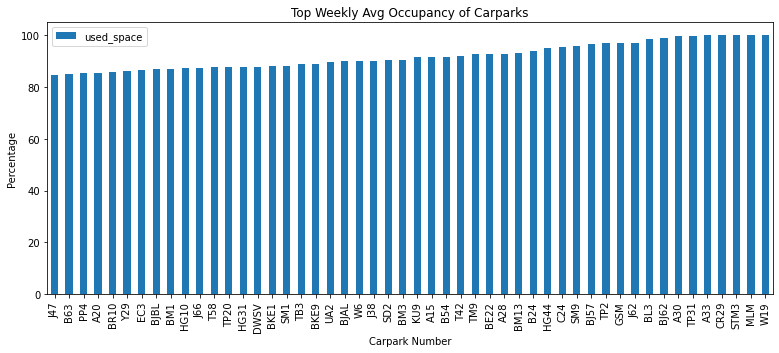

In [33]:
ax = occupancy[-50:].reset_index().plot.bar(x='carpark_number', y='used_space', figsize=(13,5))
ax.set(title='Top Weekly Avg Occupancy of Carparks', xlabel='Carpark Number', ylabel='Percentage');

### Utilization Space of the Top 3 Largest Carpark 

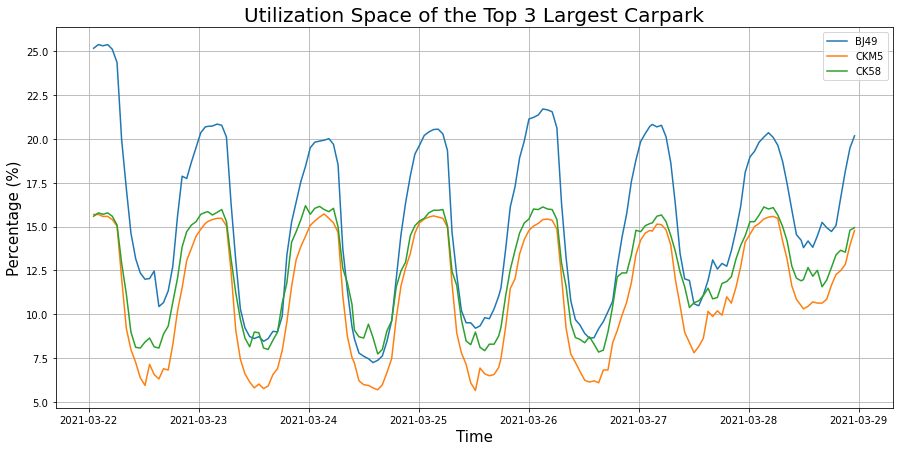

In [34]:
fig, ax = plt.subplots(figsize=(15,7))

ax.plot(df[df.carpark_number == 'BJ49'].update_datetime, df[df.carpark_number == 'BJ49']['used_space'], label='BJ49')
ax.plot(df[df.carpark_number == 'CKM5'].update_datetime, df[df.carpark_number == 'CKM5']['used_space'], label='CKM5')
ax.plot(df[df.carpark_number == 'CK58'].update_datetime, df[df.carpark_number == 'CK58']['used_space'], label='CK58')

ax.set_title('Utilization Space of the Top 3 Largest Carpark', fontsize=20)
plt.ylabel('Percentage (%)', fontsize=15)
plt.xlabel('Time', fontsize=15)
plt.grid()
plt.legend()
plt.show()

As these carparks are located in HDB areas, this graph here depicts the activities of the car owners. Used spaced are at the highest point as car owners head home for the night and daily activity such as work, resumes in the morning where majority of the car leaves. Expectedly, car owners come home later in the night during the weekend and leaves later in the morning. On top of that, residences are lessly likely to travel out on the weekend as well. Generally there's more usage of cars on the weekdays than the weekends. 

### Top 3 Underutilized Carpark

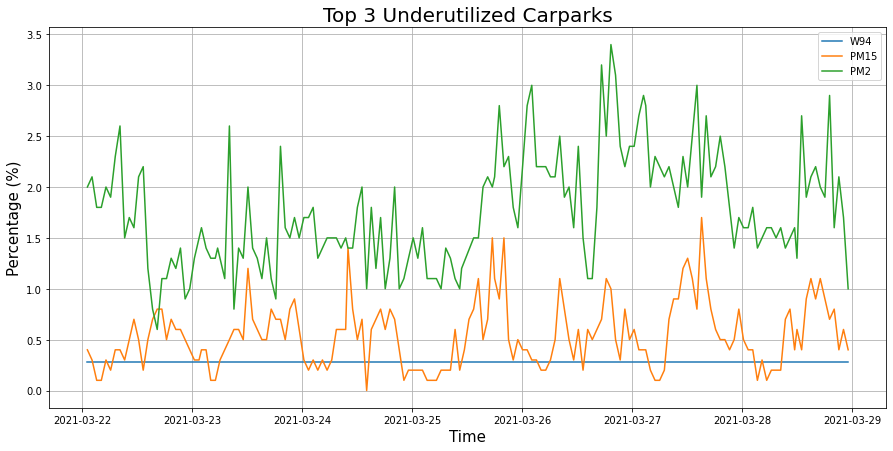

In [35]:
fig, ax = plt.subplots(figsize=(15,7))

ax.plot(df[df.carpark_number == 'W94'].update_datetime, df[df.carpark_number == 'W94']['used_space'], label='W94')
ax.plot(df[df.carpark_number == 'PM15'].update_datetime, df[df.carpark_number == 'PM15']['used_space'], label='PM15')
ax.plot(df[df.carpark_number == 'PM2'].update_datetime, df[df.carpark_number == 'PM2']['used_space'], label='PM2')

ax.set_title('Top 3 Underutilized Carparks', fontsize=20)
plt.ylabel('Percentage (%)', fontsize=15)
plt.xlabel('Time', fontsize=15)
plt.grid()
plt.legend()
plt.show()

In [36]:
# display(electronic_carpark[electronic_carpark.car_park_no == 'W94']) # Woodlands
# display(electronic_carpark[electronic_carpark.car_park_no == 'PM15']) # Pasir Ris
# display(electronic_carpark[electronic_carpark.car_park_no == 'PM2']) # Pasir Ris
# display(electronic_carpark[electronic_carpark.car_park_no == 'PM4']) # Pasir Ris
# display(electronic_carpark[electronic_carpark.car_park_no == 'TRS']) # Tanjong Rhu

As it has way lesser movement or cars, the graph here looks more erratic for both carpark PM15 and PM2 (potentially for carparks that are of low utilisation), as a result the graph is greatly influenced by the small differences.

## Summary

Based on the data collected, the largest carpark that is electronic and whole day parking is located at BLK 611A/613A/615A/616A Bukit Panjang Ring Road/Senja Road. Although it might not be of the lowest utilized carpark, it has a average utilization of 15%. This could also mean that majority of the residences living in that in the area does not own a car. 

For future studies, we could explore the number of car owners in each estates in order to target specific estates  with low number of car owners. For instance, shown in the chart below [(source)](https://www.hdb.gov.sg/-/media/doc/PLG/monograph-1-29-dec-2014.pdf), we could look more into mature towns/estates like Central Area or Queenstown area, accordingly to 2013 data. 

![alt text](./images/ownership_of_cars_of_hdb_households.png "title")

On top of that, we could also look for more options to cut cost for example prioritizing whole day electronic parking with free weekends as data shown that (probably due to Covid-19), residences are more likely to stay in for the weekend and therefore, lesser cars will be used. 